In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import lime
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import display, HTML

In [35]:

df = pd.read_csv("../data/dataproject2025_preprocessed_combined.csv")
df.head()

num__annual_inc  num__avg_cur_bal  num__bc_open_to_buy  num__bc_util  \
0        -0.740512         -0.745082             0.749479     -1.586997   
1        -0.470965         -0.250508             0.416937     -0.242629   
2         4.254853          2.390279             0.248935      0.226833   
3         0.841762          1.367198            -0.426078      1.147974   
4        -0.155910          0.630499            -0.342077      0.497129   

   num__delinq_2yrs  num__dti  num__emp_length  num__fico_range_high  \
0         -0.370384 -1.880644        -1.076012              2.106130   
1         -0.370384  0.530276         1.083330              1.258044   
2         -0.370384  0.019227        -0.266259              1.766896   
3         -0.370384 -0.633779         1.083330              0.749193   
4          0.729341  0.561034         0.003659             -0.946979   

   num__funded_amnt  num__inq_last_6mths  ...  label__emp_title  \
0         -1.180039             1.439967  ...              33.0   
1          1.180387            -0.694720  ...              33.0   
2          1.281169             0.372623  ...              41.0   
3         -0.416216             0.372623  ...              33.0   
4          1.238734             0.372623  ...              33.0   

   label__home_ownership  label__purpose  ord__grade  ord__sub_grade  \
0                    0.0             3.0         1.0             6.0   
1                    1.0             2.0         1.0             6.0   
2                    0.0             2.0         0.0             2.0   
3                    0.0             2.0         1.0             7.0   
4                    0.0             2.0         3.0            19.0   

   passthrough__issue_d  passthrough__zip_code  \
0                2013.0                  782.0   
1                2013.0                  481.0   
2                2013.0                  945.0   
3                2013.0                  809.0   
4                2013.0                  802.0   

   passthrough__Pct_afro_american  Predicted probabilities  target  
0                        7.388592                 0.053051       0  
1                        9.745456                 0.084507       0  
2                        7.542862                 0.037206       0  
3                        6.598132                 0.061371       0  
4                        7.058900                 0.345896       1  

[5 rows x 36 columns]

In [36]:
DROP_FROM_X = [
    "target",
    "Predicted probabilities",
    "Predictions",
    "passthrough__issue_d",        # time — use for split only
    "passthrough__Pct_afro_american",
    "passthrough__zip_code",
]

In [37]:
FEATURES = [c for c in df.columns if c not in DROP_FROM_X]
X = df[FEATURES]
y = df["target"].astype(int)

# Use year from the passthrough column for time split
years = df["passthrough__issue_d"].astype(int)
unique_years = np.array(sorted(years.unique()))
print("Years available:", unique_years)

Years available: [2012 2013 2014 2015 2016 2017 2018 2019 2020]


In [38]:
# Generic rule: train = all but last 2 years; valid = penultimate year; test = last year
if len(unique_years) >= 3:
    train_years = unique_years[:-2]
    valid_years = unique_years[-2:-1]
    test_years  = unique_years[-1:]
else:
    # fallback if fewer than 3 years are present
    train_years = unique_years[:1]
    valid_years = unique_years[1:2]
    test_years  = unique_years[2:3]

print("Train years:", train_years, "Valid year(s):", valid_years, "Test year(s):", test_years)

Train years: [2012 2013 2014 2015 2016 2017 2018] Valid year(s): [2019] Test year(s): [2020]


In [39]:
train_idx = years.isin(train_years)
valid_idx = years.isin(valid_years)
test_idx  = years.isin(test_years)

X_train, y_train = X[train_idx], y[train_idx]
X_valid, y_valid = X[valid_idx], y[valid_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Shapes -> Train:", X_train.shape, y_train.mean(),
      "Valid:", X_valid.shape, y_valid.mean(),
      "Test:",  X_test.shape,  y_test.mean())

Shapes -> Train: (1052038, 31) 0.21190774477727992 Valid: (32368, 31) 0.17613074641621354 Test: (1830, 31) 0.006557377049180328


In [40]:
# RE SPLIT

unique_years = np.array(sorted(np.unique(years)))
assert len(unique_years) >= 4, f"Need >=4 years, got {unique_years}"

train_years = unique_years[:-3]
valid_years = unique_years[-3:-2]
test_years  = unique_years[-2:]

train_idx = years.isin(train_years)
valid_idx = years.isin(valid_years)
test_idx  = years.isin(test_years)

X_train, y_train = X[train_idx], y[train_idx]
X_valid, y_valid = X[valid_idx], y[valid_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Years:", unique_years)
print("Train/Valid/Test sizes:", len(y_train), len(y_valid), len(y_test))
print("Prevalence -> Train:", y_train.mean(), "Valid:", y_valid.mean(), "Test:", y_test.mean())

Years: [2012 2013 2014 2015 2016 2017 2018 2019 2020]
Train/Valid/Test sizes: 957145 94893 34198
Prevalence -> Train: 0.20750669961186655 Valid: 0.25629920015174984 Test: 0.1670565530147962


In [41]:
with open("../models/step2_catboost_timesplit.pkl", "rb") as f:
    cb = pkl.load(f)

### Part 1: LIME

In [42]:
# LIME training matrix
feature_names = list(X_train.columns)
class_names = [str(c) for c in sorted(np.unique(y_train))]

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,      
    sample_around_instance=True,     
    random_state=42
)

# Prediction function that LIME will call
def predict_proba_lime(numpy_matrix: np.ndarray) -> np.ndarray:
    # Convert back to DataFrame with identical column order
    df_ = pd.DataFrame(numpy_matrix, columns=feature_names)
    return cb.predict_proba(df_)


In [43]:
# Checking for first instance in test set
exp = explainer.explain_instance(
    data_row=X_test.iloc[0].values,
    predict_fn=predict_proba_lime,
    num_features=10,
    top_labels=1,
    num_samples=5000 
)
html = exp.as_html(show_table=True)
styled_html = f"""
<div style="background-color:white; color:black; font-size:18px; line-height:1.5; padding:20px;">
  
  {html}
</div>
"""

display(HTML(styled_html))

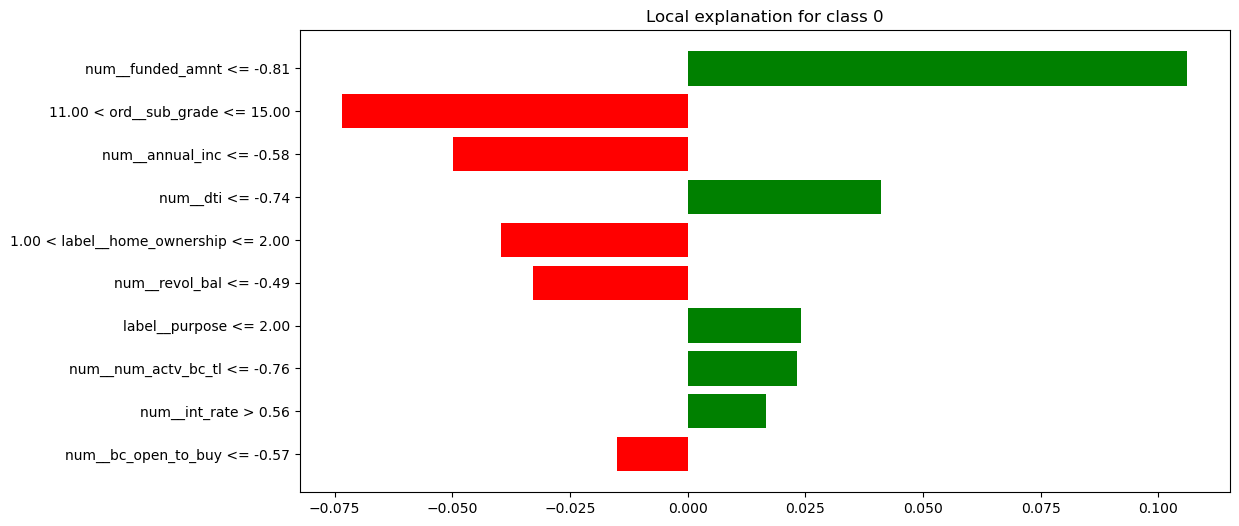

In [44]:
fig = exp.as_pyplot_figure(label=list(exp.local_exp.keys())[0])
fig.set_size_inches(12, 6)  
plt.show()

In [45]:
# Checking for another instance in test set
exp = explainer.explain_instance(
    data_row=X_test.iloc[10].values,
    predict_fn=predict_proba_lime,
    num_features=10,
    top_labels=1,
    num_samples=5000 
)
html = exp.as_html(show_table=True)
styled_html = f"""
<div style="background-color:white; color:black; font-size:18px; line-height:1.5; padding:20px;">
  
  {html}
</div>
"""

display(HTML(styled_html))

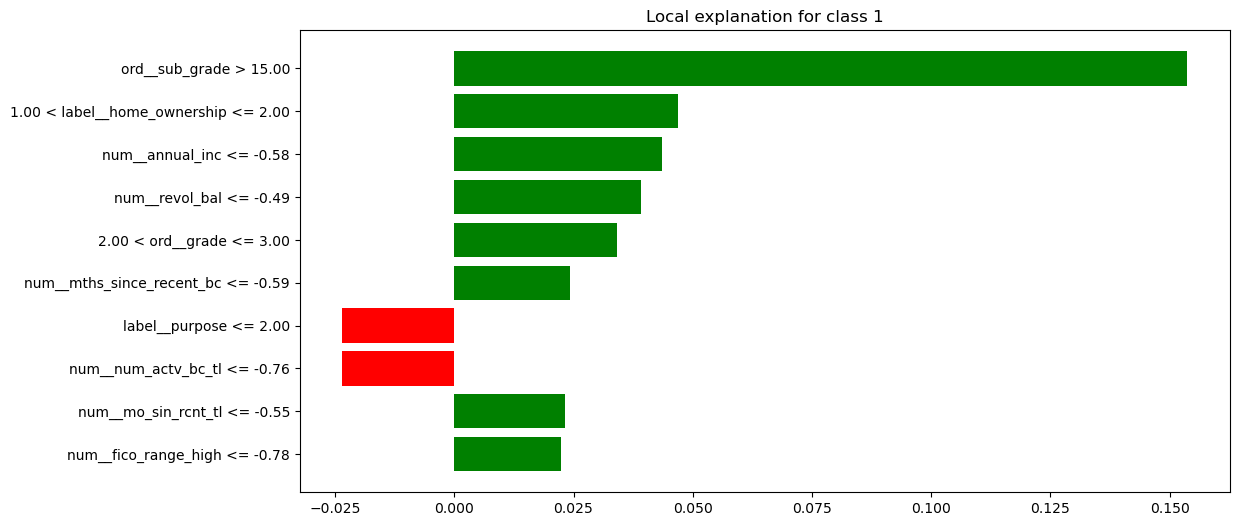

In [46]:
fig = exp.as_pyplot_figure(label=list(exp.local_exp.keys())[0])
fig.set_size_inches(12, 6)  
plt.show()

### Part 2: ICE

In [47]:
def _predict(est, X_df, kind="proba", target_class=1):
    if kind == "proba":
        proba = est.predict_proba(X_df)
        return proba[:, target_class] if proba.ndim == 2 else proba
    return est.predict(X_df)

def _grid_from(values, grid_points=50):
    vmin, vmax = np.nanmin(values), np.nanmax(values)
    if vmin == vmax:
        return np.array([vmin])
    return np.linspace(vmin, vmax, grid_points)

def centered_ice_plot(
    est,
    X: pd.DataFrame,
    feature: str,
    kind: str = "proba",      
    target_class: int = 1,    
    n_instances: int = 200,   # number of ICE lines
    grid_points: int = 60,    
    random_state: int = 42,
    figsize=(10, 6)            
):
    assert feature in X.columns, f"{feature} not in X"

    rng = np.random.default_rng(random_state)
    # sample instances for ICE
    if (n_instances is None) or (n_instances >= len(X)):
        X_ice = X.copy()
    else:
        idx = rng.choice(len(X), size=n_instances, replace=False)
        X_ice = X.iloc[idx].copy()

    # grid and anchor (min grid value, per slide)
    grid = _grid_from(X[feature].values, grid_points)
    anchor = grid[0]

    # predictions at anchor for centering
    X_anchor = X_ice.copy()
    X_anchor[feature] = anchor
    base = _predict(est, X_anchor, kind=kind, target_class=target_class)   # (m,)

    # ICE curves on grid
    m, G = len(X_ice), len(grid)
    ice = np.zeros((m, G), dtype=float)
    for j, v in enumerate(grid):
        X_tmp = X_ice.copy()
        X_tmp[feature] = v
        ice[:, j] = _predict(est, X_tmp, kind=kind, target_class=target_class)

    # Centered ICE: subtract baseline at anchor so every line starts at 0
    cice = ice - base[:, None]

    # Partial Dependence (mean of ICE), also centered at anchor
    # (equivalent to averaging cICE across instances)
    pd_centered = cice.mean(axis=0)

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)
    # thin gray ICE lines
    for i in range(m):
        ax.plot(grid, cice[i, :], color="0.6", linewidth=0.8, alpha=0.6)
    # thick yellow PD line on top
    ax.plot(grid, pd_centered, linewidth=4, color="#FF0000", zorder=5)

    # rug plot of observed X values at bottom
    y_rug = np.full(len(X), cice.min() - 0.03 * (cice.max() - cice.min()))
    ax.plot(X[feature].values, y_rug, "|", color="0.5", markersize=8, alpha=0.6)

    # axes & labels (slide-like)
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Prediction centered at x = {anchor:.3g}")
    ax.axhline(0, color="0.7", linestyle="--", linewidth=1)
    ax.set_title(f"Centered ICE for '{feature}'")

    plt.tight_layout()
    plt.show()

    return {"grid": grid, "cice": cice, "pd_centered": pd_centered, "anchor": anchor}

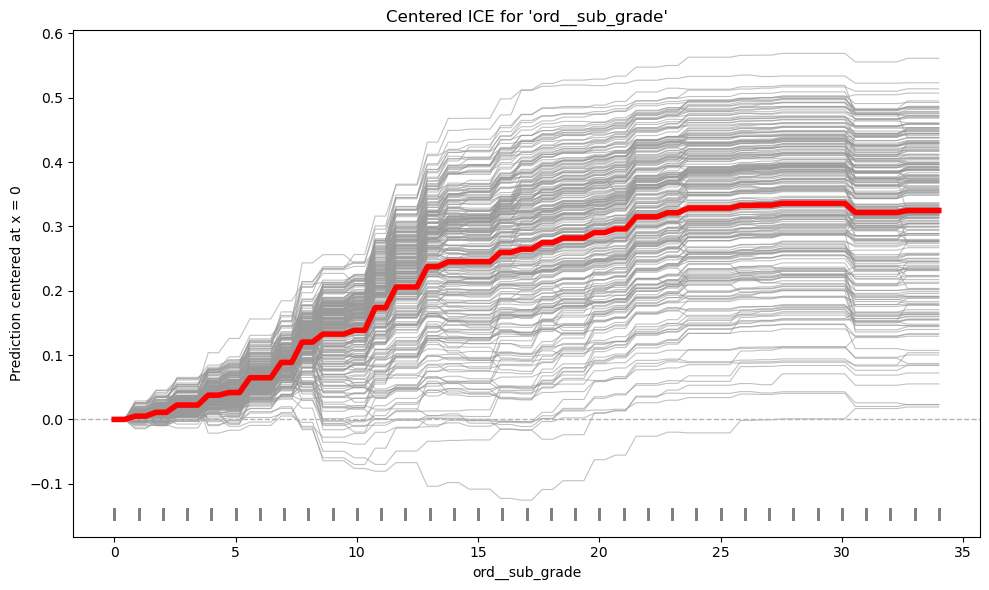

In [48]:
# Centered ICE for ord_sub_grade
out = centered_ice_plot(
    est=cb,
    X=X_train,
    feature="ord__sub_grade",
    kind="proba",
    target_class=1,
    n_instances=250,
    grid_points=80,
    figsize=(10,6)
)

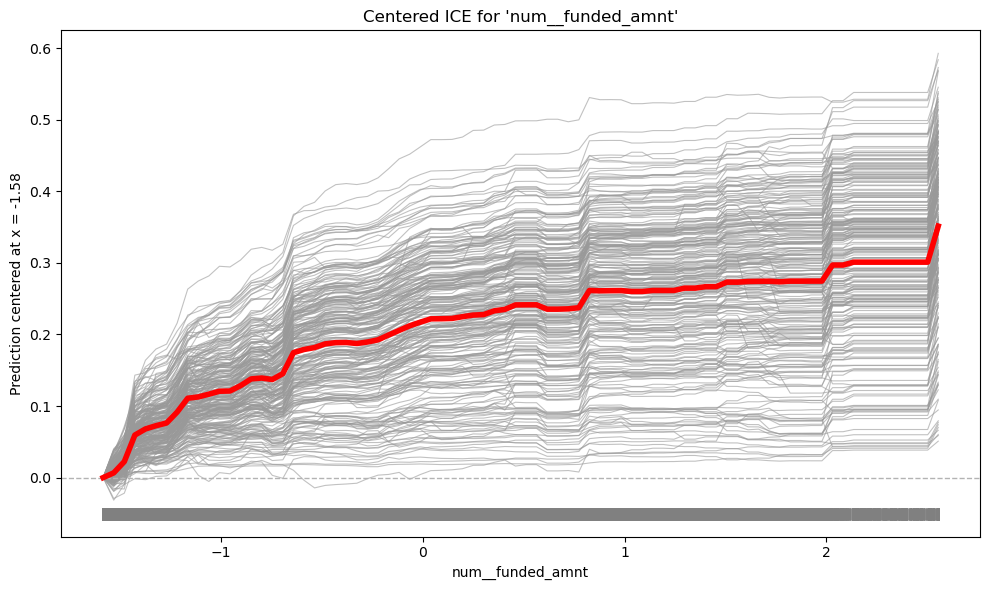

In [49]:
# Centered ICE for num__funded_amnt
out = centered_ice_plot(
    est=cb,
    X=X_train,
    feature="num__funded_amnt",
    kind="proba",
    target_class=1,
    n_instances=250,
    grid_points=80,
    figsize=(10,6)
)

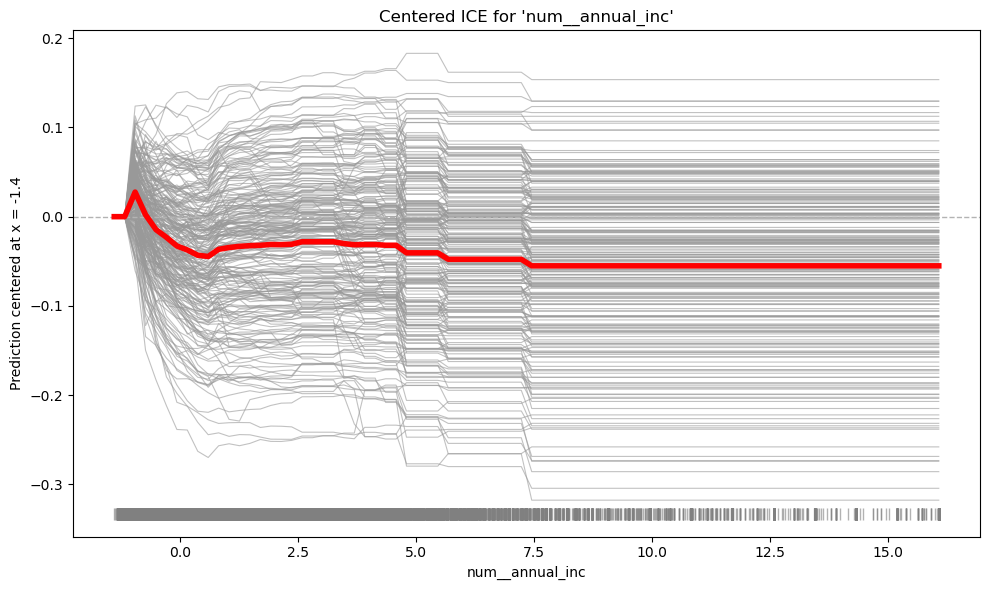

In [50]:
# Centered ICE for num__annual_inc
out = centered_ice_plot(
    est=cb,
    X=X_train,
    feature="num__annual_inc",
    kind="proba",
    target_class=1,
    n_instances=250,
    grid_points=80,
    figsize=(10,6)
)